# 0.0 Import modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

from itertools import product as prod
from collections import defaultdict

from scipy import stats as ss

from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder

## 0.1 Problema

Uma seguradora de planos de saúde pretende passar a vender, também, seguros de automóveis.

A seguradora realizou pesquisa com cerca de 380.000 clientes para saber se teriam interesse, ou não, em contrtar o novo seguro. Todos os clientes responderam.

A seguradora selecionou cerca de 127.000 potenciais clientes para participar de uma campanha. Este grupo receberá a oferta de adesão ao seguro de automóvel via ligação telefônica.

**Problema**: o time de vendas tem condições de ligar para, somente, 20.000 pessoas. Como selecionar, dentre os potenciais clientes, aqueles que tem maior probabilidade de adquirir o seguro?

O *relatório* deve responder às seguintes questões:

1. Fornecer *insights* sobre os atributos mais relevantes de clientes interessados em adquirir o seguro.

2. Qual porcentagem dos potenciais clientes interessados o time de vendas vai conseguir aontatar fazendo 20.000 ligações?

3. Se o time de vendas fizer 40.000 ligações, qual será a porcentagem de clientes interessados contatada?

4. Quantas ligações o time de vendas precisariaria fazer para contatar 80% dos potenciais clientes interessados?

## 0.2 Load data

The file "table.csv" contains only the train data. The test data is in a separate file, "test.csv", which was downloaded via Kaggle's API.

In [2]:
df_train_raw = pd.read_csv('table.csv')

In [3]:
df_train_raw.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0


A variável *response* é a variável resposta (target). As outras variáveis são as características (features).

## 0.3 Plano de solução

Após a limpeza dos dados, checarei algumas hipóteses (lista logo abaixo) que gerarão insights sobre a revelância dos atributos para o interesse dos clientes em adquirir o seguro de automóveis.

Utilizarei algum método de redução de dimensionalidade para encontrar quais atributos mais contribuem para a variância (Boruta).

Identificados os atributos, resta resolver um problema de clusterização: dividir os dados de teste em "interesse" e "não interesse", de acordo com os atributos daqueles dados. *Os dados de teste não tem a variável target, pois o time de vendas ainda não contatou aqueles potenciais clientes*. MiniBatchKMeans?

Contar os potenciais clientes classificados como "interesse" e responder às demais perguntas do relatório.

# 1.0 Análise descritiva dos dados

In [4]:
df1 = df_train_raw.copy()

## 1.1 Check and fill NA

In [5]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.2 Data types

In [6]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

The features "driving_license", "previously_insured", "id", "region_code" and "policy_sales_channel" will remain as numerical variables. The only modification will be to write all of them as integers.

In [7]:
df1['region_code'] = df1['region_code'].astype(int)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)

In [8]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code               int64
policy_sales_channel      int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

I don't know if it's better to separate the feature and target variables at this point. If I don't, I might alter the target values (by some mean, for example). Whereas if I do, I might, in the feature engineering process, change the order of the samples and create a mess! 

## 1.3 Descriptive Statistics

In [9]:
num_attr = df1.select_dtypes(include=('int64', 'float64'))
cat_attr = df1.select_dtypes(include=['object'])

### 1.3.1 Numerical attributes

In [10]:
aux1 = num_attr.drop(columns=['id', 'region_code', 'policy_sales_channel'])

num_desc = aux1.describe()
num_range = pd.DataFrame(aux1.apply(lambda x: x.max() - x.min()), columns=['range']).T
num_skew = pd.DataFrame(aux1.skew(), columns=['skew']).T
num_kurt = pd.DataFrame(aux1.kurt(), columns=['kurtosis']).T

num_stat = pd.concat([num_desc, num_range, num_skew, num_kurt]).T.drop(columns=['count'])
num_stat

,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
age,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,65.0,0.672539,-0.565655
driving_license,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0,1.0,-21.595182,464.354302
previously_insured,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0,1.0,0.167747,-1.971871
annual_premium,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0,537535.0,1.766087,34.004569
vintage,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,289.0,0.003030,-1.200688
response,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0,1.0,2.301906,3.298788


Most customers answered that they are not interested in a car insurance. Only 12% answered 'yes' on the survey.

Also, most customers have a driving license.

Less than half of the customers were previously insured.

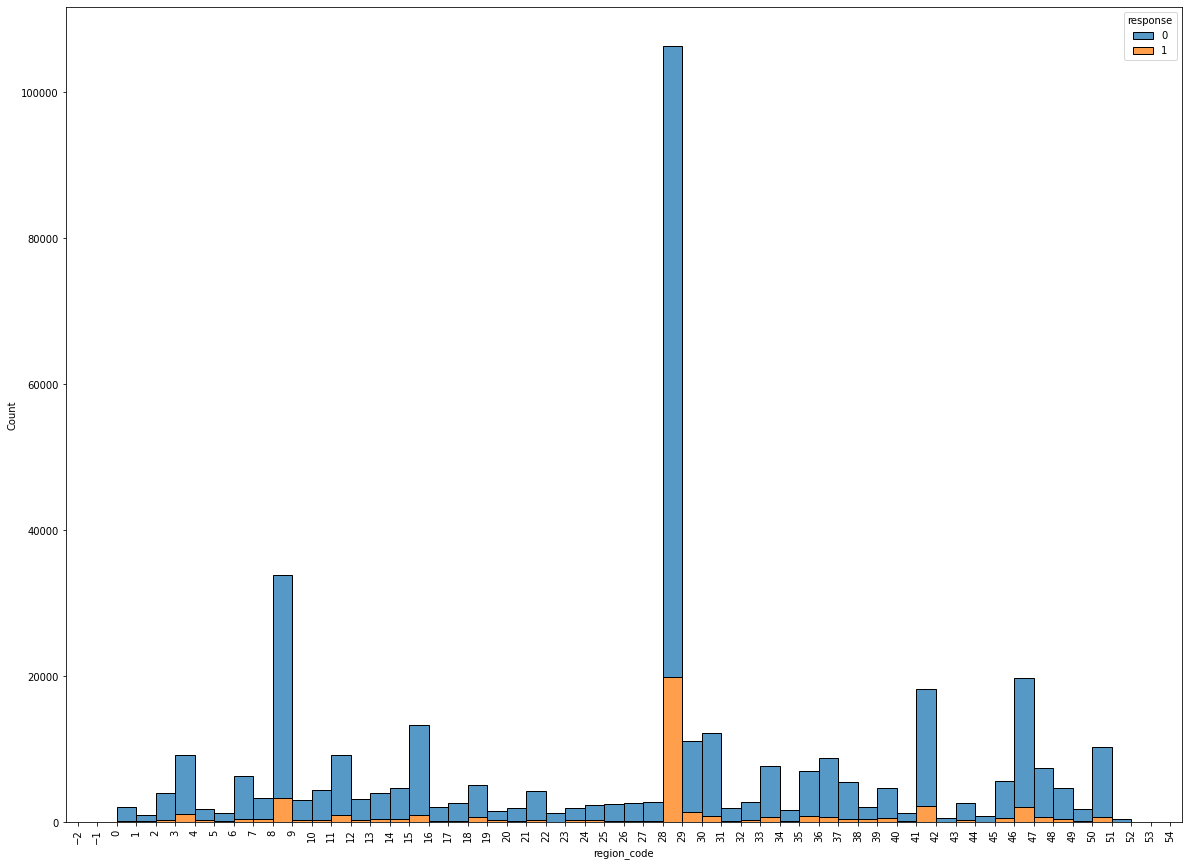

In [11]:
plt.figure(figsize=(20,15));

ax = plt.gca();

sns.histplot(data=num_attr, x='region_code', hue='response', multiple='stack', binwidth=1);
plt.xticks(rotation=90);
ax.xaxis.set_major_locator(ticker.MultipleLocator(1));
plt.show();

### 1.3.2 Categorical attributes

Count number of categories in each feature

In [12]:
cat_attr.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

I will drop 'id' and 'policy_sales_channel' from the descriptive statistics analysis

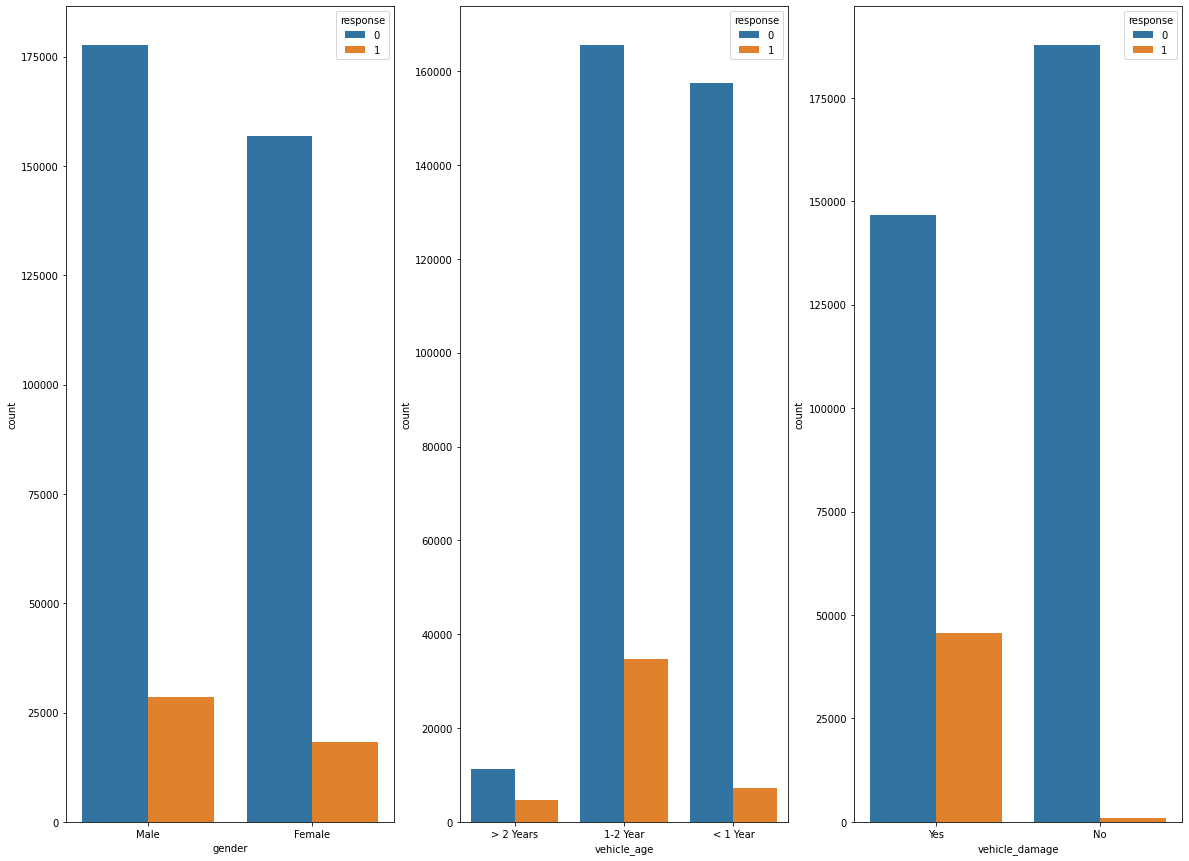

In [13]:
plt.figure(figsize=(20, 15))


plt.subplot(1, 3, 1)
sns.countplot(data=df1, x='gender', hue='response');#, multiple='stack');

plt.subplot(1, 3, 2)
sns.countplot(data=df1, x='vehicle_age', hue='response');#, multiple='stack');

plt.subplot(1, 3, 3)
sns.countplot(data=df1, x='vehicle_damage', hue='response');#, multiple='stack');

# 2.0 Feature Engineering

In [14]:
df2 = df1.copy()

## 2.1 Hipóteses

**1** Clientes sem licença tem menos probabilidade de adquirir seguro de automóvel.

**2** Clientes menores de idade tem menos probabilidade de adquirir seguro de automóvel.

**3** Clientes não-idosos tem maior probabilidade de adquirir seguro de automóvel.

**4** Clientes mulheres tem maior probabilidade de adquirir seguro de automóvel.

**5** Clientes com carros mais antigos tem menor probabilidade de adquirir seguro de automóvel.

**6** Clientes que já tiveram seu veículo danificado tem maior probabilidade de adquirir seguro de automóvel.

**7** Clientes há mais tempo tem maior probabilidade de adquirir seguro de automóvel.

**8** Clientes que pagam mais pelo seguro saúde tem maior probabilidade de adquirir seguro de automóvel.

## 2.2 Hipóteses que serão testadas:

**1** Clientes sem licença tem meno probabilidade de adquirir seguro de automóvel.

<s>**2** Clientes menores de idade tem menos probabilidade de adquirir seguro de automóvel.</s>
Todos os clientes entrevistados são maiores de idade.

**3** Clientes não-idosos tem maior probabilidade de adquirir seguro de automóvel.

**4** Clientes mulheres tem maior probabilidade de adquirir seguro de automóvel.

**5** Clientes com carros mais antigos tem menor probabilidade de adquirir seguro de automóvel.

**6** Clientes que já tiveram seu veículo danificado tem maior probabilidade de adquirir seguro de automóvel.

**7** Clientes há mais tempo tem maior probabilidade de adquirir seguro de automóvel.

**8** Clientes que pagam mais pelo seguro saúde tem maior probabilidade de adquirir seguro de automóvel.

## 2.3 Feature Engineering

I will derive some new features, representing customer loyalty, history and income estimate.

In [15]:
df2['vehicle_damage'].replace({'Yes':1 , 'No':0}, inplace=True)

In [16]:
#customer loyalty
#gender
aux1 = df2.groupby('gender')['vintage'].mean().to_dict()
gender_loyalty = []
for i in range(df2.shape[0]):
    gender_loyalty.append(aux1[df2.loc[i, 'gender']])

df2['gender_loyalty'] = gender_loyalty


#age
aux2 = df2.groupby('age')['vintage'].mean().to_dict()
age_loyalty = []
for i in range(df2.shape[0]):
    age_loyalty.append(aux2[df2.loc[i, 'age']])

df2['age_loyalty'] = age_loyalty


#region
aux3 = df2.groupby('region_code')['vintage'].mean().to_dict()
region_loyalty = []
for i in range(df2.shape[0]):
    region_loyalty.append(aux3[df2.loc[i, 'region_code']])

df2['region_loyalty'] = region_loyalty



#customer history
#gender
aux4 = df2.groupby('gender')['previously_insured'].mean().to_dict()
gender_prev_ins = []
for i in range(df2.shape[0]):
    gender_prev_ins.append(aux4[df2.loc[i, 'gender']])

df2['gender_prev_ins'] = gender_prev_ins


#age
aux5 = df2.groupby('age')['previously_insured'].mean().to_dict()
age_prev_ins = []
for i in range(df2.shape[0]):
    age_prev_ins.append(aux5[df2.loc[i, 'age']])

df2['age_prev_ins'] = age_prev_ins


#gender_damage
aux6 = df2.groupby('gender')['vehicle_damage'].mean().to_dict()
gender_accident = []
for i in range(df2.shape[0]):
    gender_accident.append(aux6[df2.loc[i, 'gender']])

df2['gender_accident'] = gender_accident


#age_damage
aux7 = df2.groupby('age')['vehicle_damage'].mean().to_dict()
age_accident = []
for i in range(df2.shape[0]):
    age_accident.append(aux7[df2.loc[i, 'age']])

df2['age_accident'] = age_accident



#regional features
#region_insurance
aux8 = df2.groupby('region_code')['previously_insured'].mean().to_dict()
region_ins = []
for i in range(df2.shape[0]):
    region_ins.append(aux8[df2.loc[i, 'region_code']])

df2['region_ins'] = region_ins


#region_accident
aux9 = df2.groupby('region_code')['vehicle_damage'].mean().to_dict()
region_accident = []
for i in range(df2.shape[0]):
    region_accident.append(aux9[df2.loc[i, 'region_code']])

df2['region_accident'] = region_accident



#income estimate
#gender
aux10 = df2.groupby('gender')['annual_premium'].mean().to_dict()
gender_premium = []
for i in range(df2.shape[0]):
    gender_premium.append(aux10[df2.loc[i, 'gender']])

df2['gender_premium'] = gender_premium


#age
aux11 = df2.groupby('age')['annual_premium'].mean().to_dict()
age_premium = []
for i in range(df2.shape[0]):
    age_premium.append(aux11[df2.loc[i, 'age']])

df2['age_premium'] = age_premium


#region
aux12 = df2.groupby('region_code')['annual_premium'].mean().to_dict()
region_premium = []
for i in range(df2.shape[0]):
    region_premium.append(aux12[df2.loc[i, 'region_code']])

df2['region_premium'] = region_premium

In [17]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,...,region_loyalty,gender_prev_ins,age_prev_ins,gender_accident,age_accident,region_ins,region_accident,gender_premium,age_premium,region_premium
0,1,Male,44,28,26,1,> 2 Years,1,0,40454.0,...,154.396965,0.420590,0.269714,0.547084,0.690559,0.311817,0.660020,30622.649122,31227.811894,38668.865245
1,2,Male,76,3,26,1,1-2 Year,0,0,33536.0,...,155.211437,0.420590,0.378940,0.547084,0.599570,0.488704,0.478435,30622.649122,34640.320201,24524.480813
2,3,Male,47,28,26,1,> 2 Years,1,0,38294.0,...,154.396965,0.420590,0.274793,0.547084,0.692423,0.311817,0.660020,30622.649122,31410.618827,38668.865245
3,4,Male,21,11,152,1,< 1 Year,0,1,28619.0,...,154.607777,0.420590,0.528650,0.547084,0.445039,0.619367,0.357777,30622.649122,30591.404448,27607.283146
4,5,Female,29,41,152,1,< 1 Year,0,1,27496.0,...,154.933089,0.502508,0.618791,0.455177,0.337057,0.564694,0.416470,30495.787990,27865.179297,30949.127471


# 3.0 Filtragem das variáveis

In [18]:
df3 = df2.copy()

In [19]:
df3 = df3.drop(columns=['policy_sales_channel'])

# 4.0 Análise Exploratória dos Dados

In [20]:
df4 = df3.copy()

In [21]:
num_attr = df4.select_dtypes(include=('int64', 'float64'))
cat_attr = df4.select_dtypes(include=['object'])

## 4.1 Análise Univariada

### 4.1.1 Response Variable

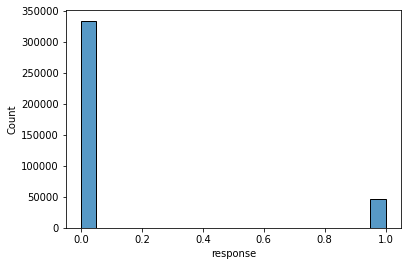

In [22]:
sns.histplot(data = df4, x='response');

### 4.1.2 Numerical Variables

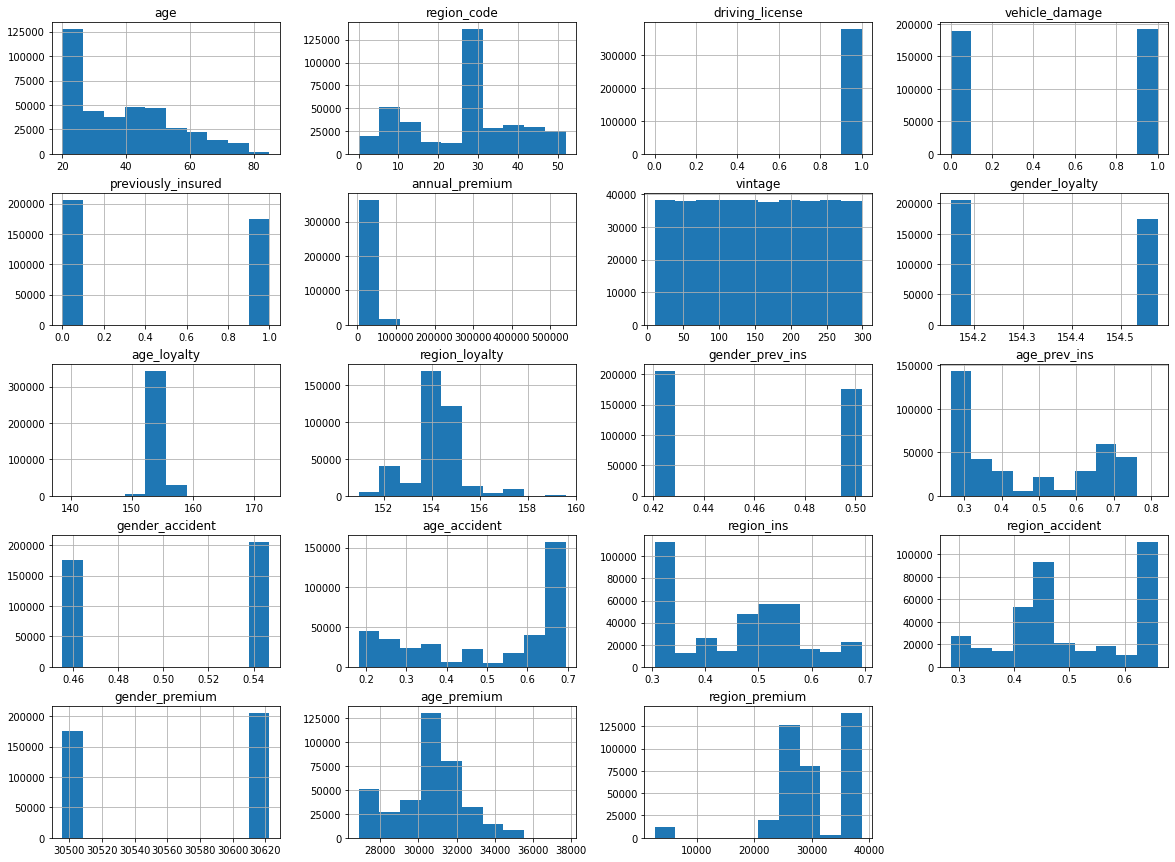

In [23]:
num_attr.drop(columns=['id', 'response']).hist(figsize=(20, 15));

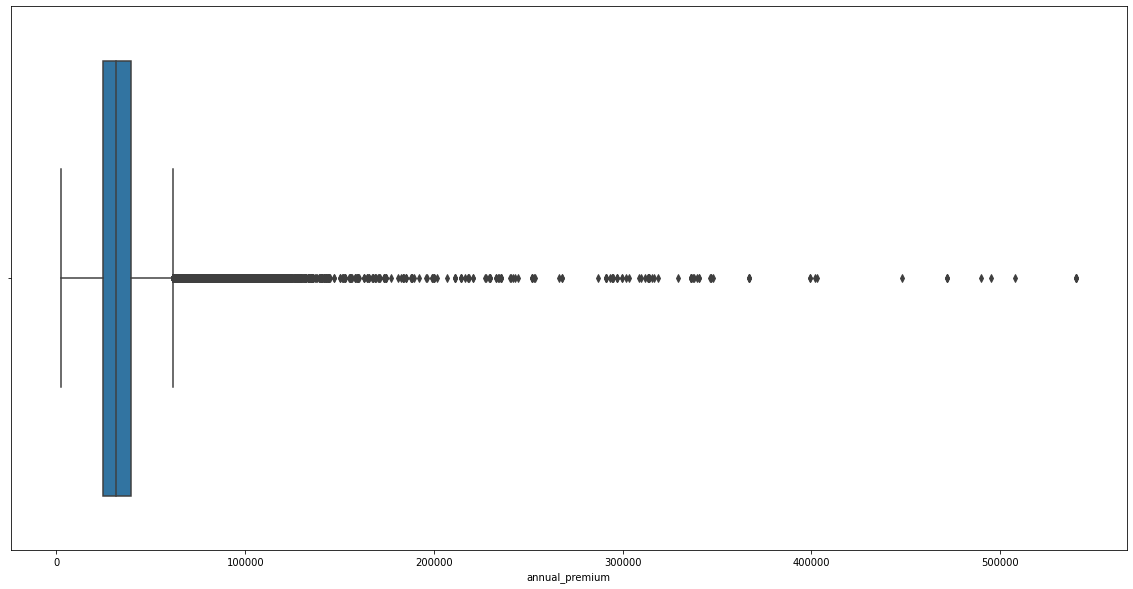

In [24]:
plt.figure(figsize=(20,10))
sns.boxplot(data=num_attr, x='annual_premium');

### 4.1.3 Categorical Variables

In [25]:
cat_attr.head()

,gender,vehicle_age
0,Male,> 2 Years
1,Male,1-2 Year
2,Male,> 2 Years
3,Male,< 1 Year
4,Female,< 1 Year


These variables will be displayed together with their percent counterparts

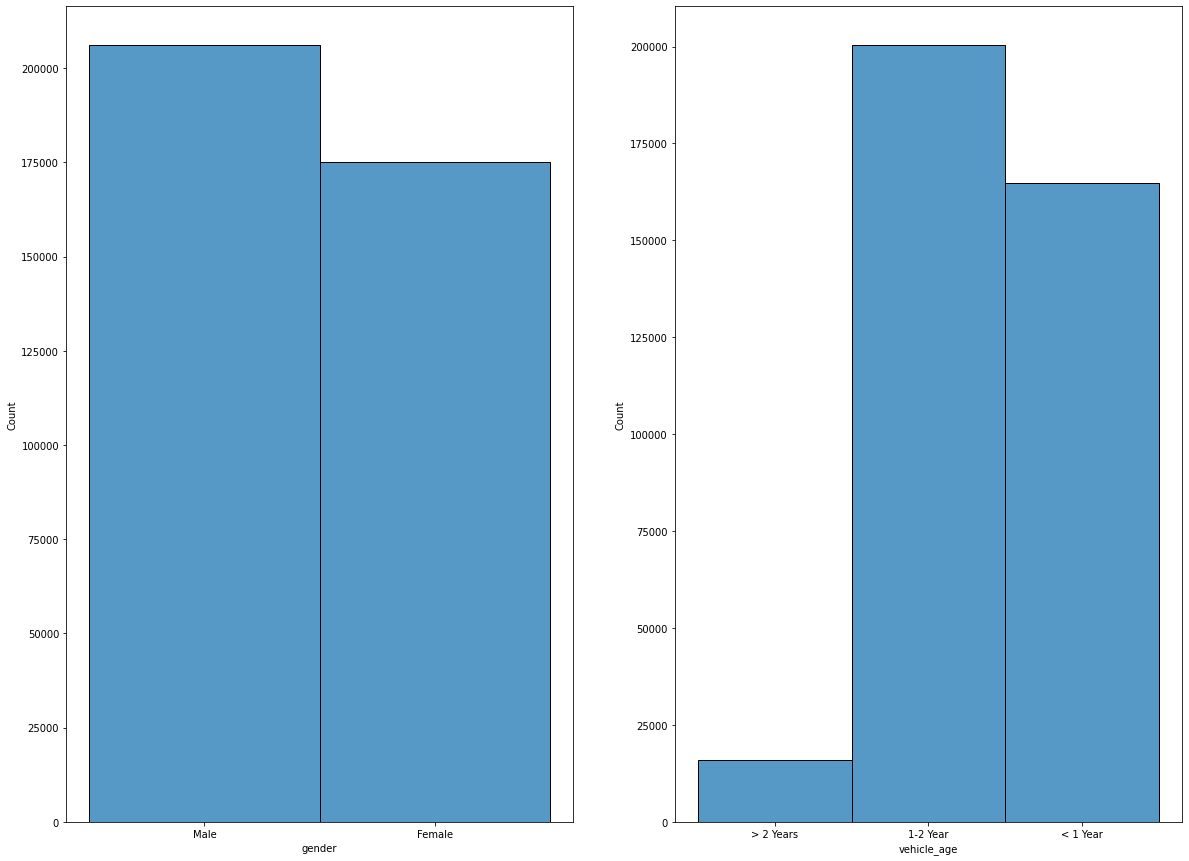

In [26]:
plt.figure(figsize=(20, 15))


plt.subplot(1, 2, 1)
sns.histplot(data=cat_attr, x='gender');

plt.subplot(1, 2, 2)
sns.histplot(data=cat_attr, x='vehicle_age');

## 4.2 Análise Bivariada

In [27]:
df4_1 = df4[df4['response'] == 1]

**H1** Clientes sem licença tem menor probabilidade de adquirir seguro de automóvel.

**Verdadeira**

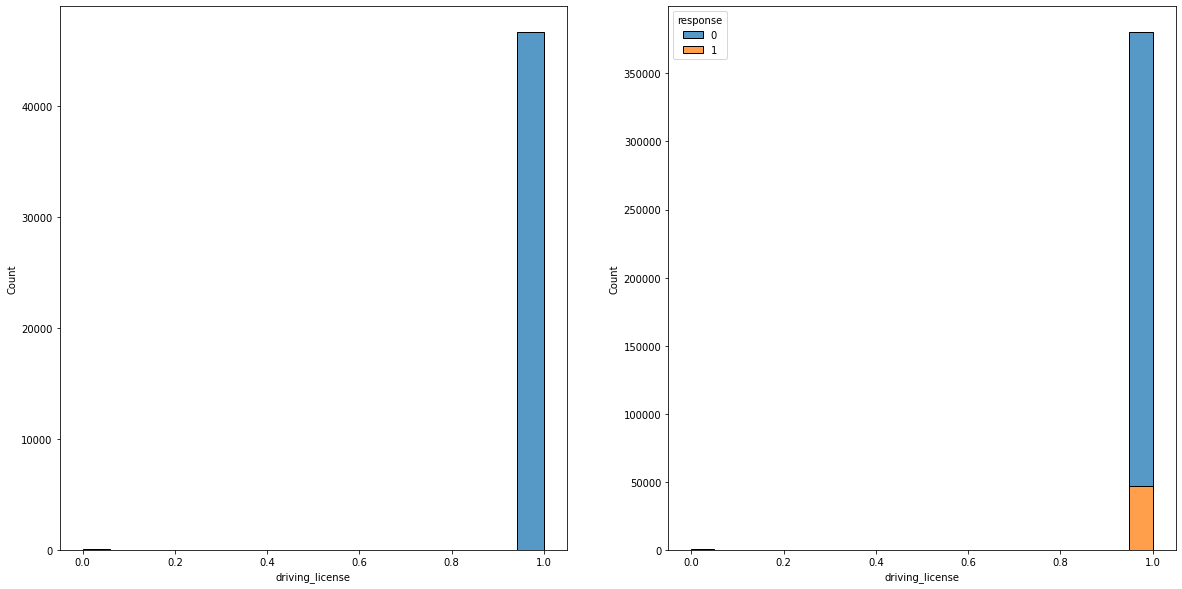

In [28]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
sns.histplot(data=df4_1, x='driving_license');

plt.subplot(1, 2, 2)
sns.histplot(data=df4, x='driving_license', hue='response', multiple='stack');

**H2** Clientes não-idosos tem maior probabilidade de adquirir seguro de automóvel.

**Verdadeira**

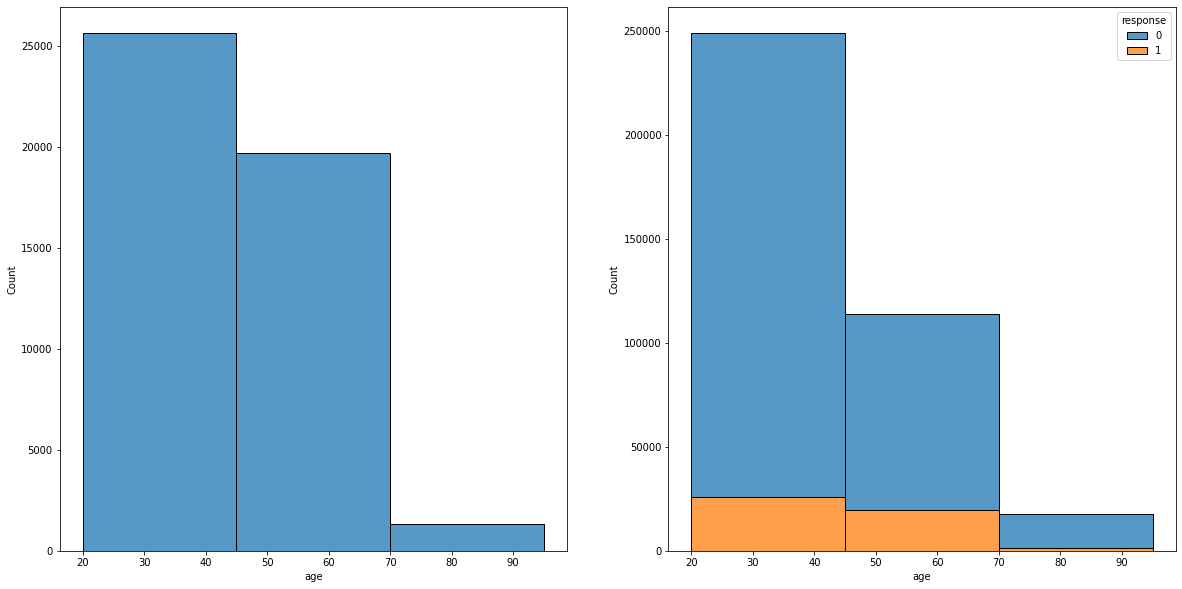

In [29]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
sns.histplot(data=df4_1, x='age', binwidth=25);

plt.subplot(1, 2, 2)
sns.histplot(data=df4, x='age', binwidth=25, hue='response', multiple='stack');

**H3** Clientes mulheres tem maior probabilidade de adquirir seguro de automóvel.

**Falsa** Clientes homens tem maior probabilidade de adquirir seguro de automóvel.

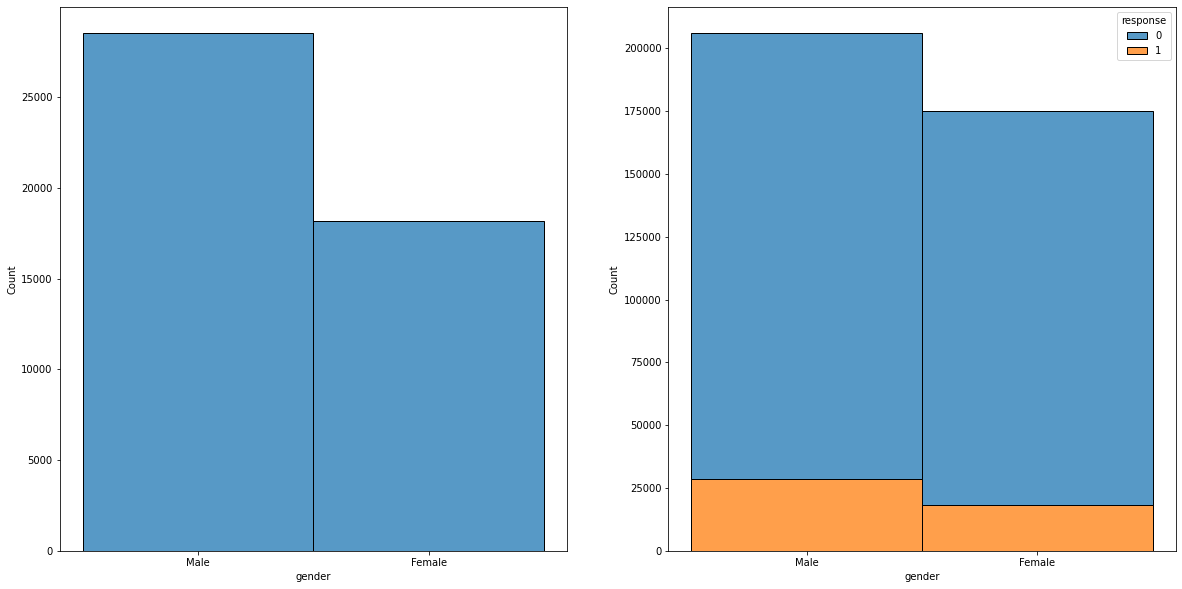

In [30]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
sns.histplot(data=df4_1, x='gender');

plt.subplot(1, 2, 2)
sns.histplot(data=df4, x='gender', hue='response', multiple='stack');

**H4** Clientes com carros mais antigos tem menor probabilidade de adquirir seguro de automóvel.

**Verdadeira**

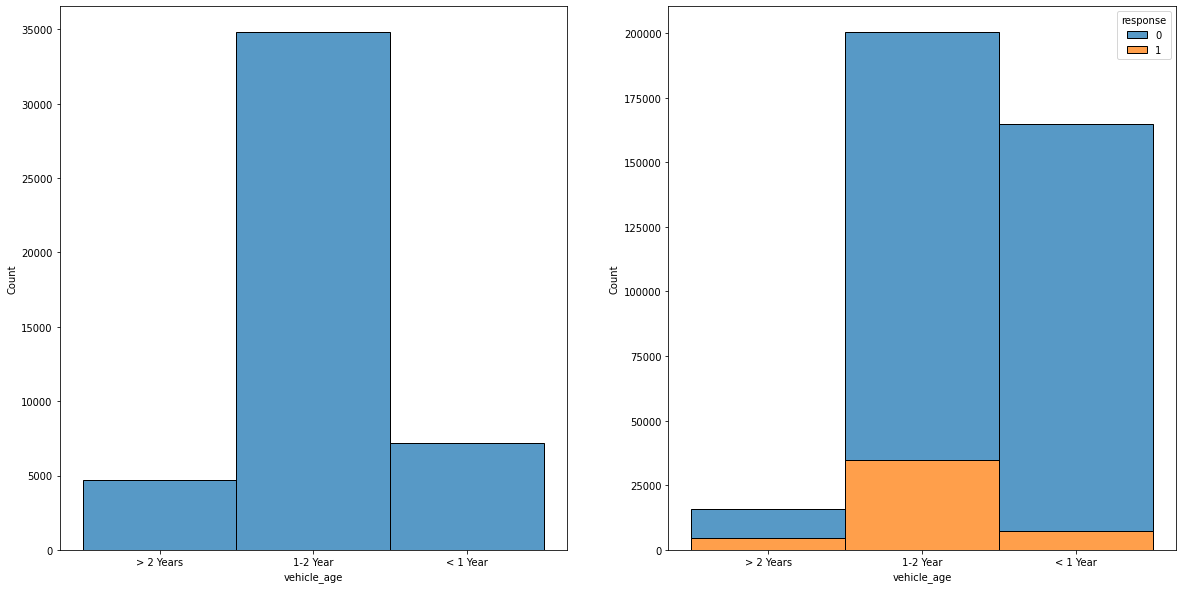

In [31]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
sns.histplot(data=df4_1, x='vehicle_age');

plt.subplot(1, 2, 2)
sns.histplot(data=df4, x='vehicle_age', hue='response', multiple='stack');

**H5** Clientes que já tiveram seu veículo danificado tem maior probabilidade de adquirir seguro de automóvel.

**Verdadeira**

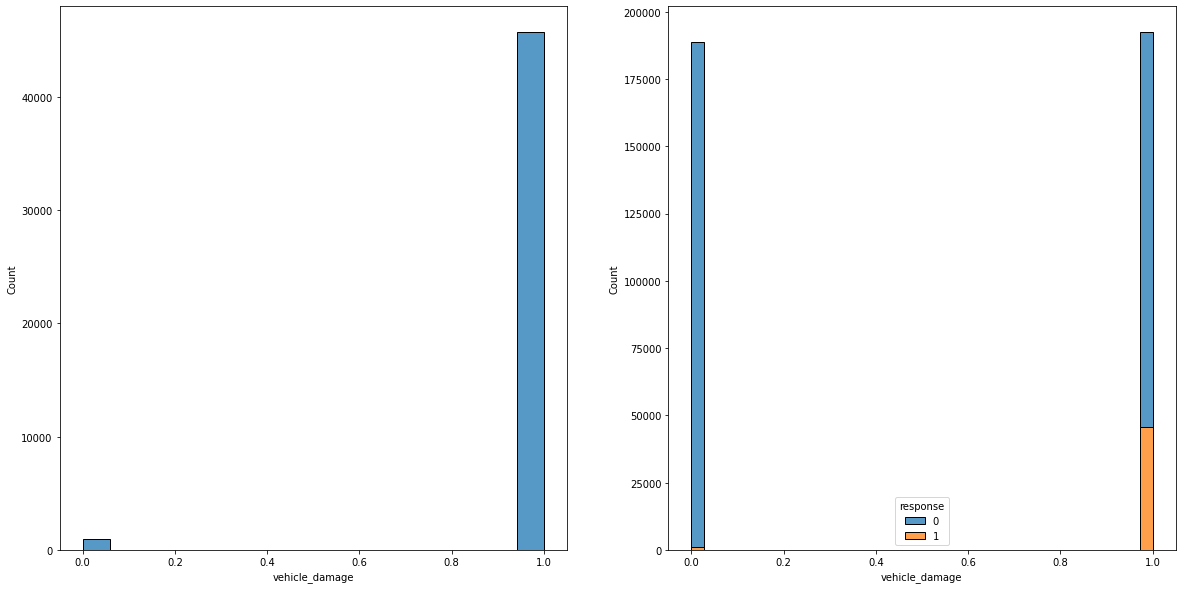

In [32]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
sns.histplot(data=df4_1, x='vehicle_damage');

plt.subplot(1, 2, 2)
sns.histplot(data=df4, x='vehicle_damage', hue='response', multiple='stack');

**H6** Clientes há mais tempo tem maior probabilidade de adquirir seguro de automóvel.

**Falsa** Não há correlação notável entre "vintage" e o seguro de automóvel.

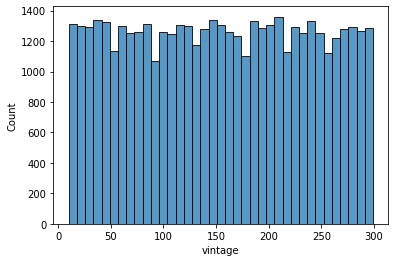

In [33]:
sns.histplot(data=df4_1, x='vintage');

**H7** Clientes que pagam mais pelo seguro saúde tem maior probabilidade de adquirir seguro de automóvel.

**Falsa**

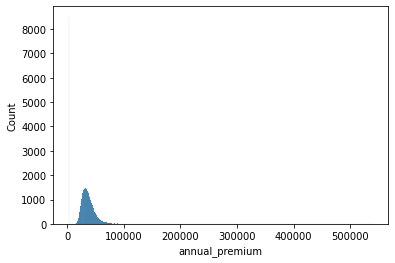

In [34]:
sns.histplot(data=df4_1, x='annual_premium');

## 4.3 Análise Multivariada

### 4.3.1 Variáveis Numéricas

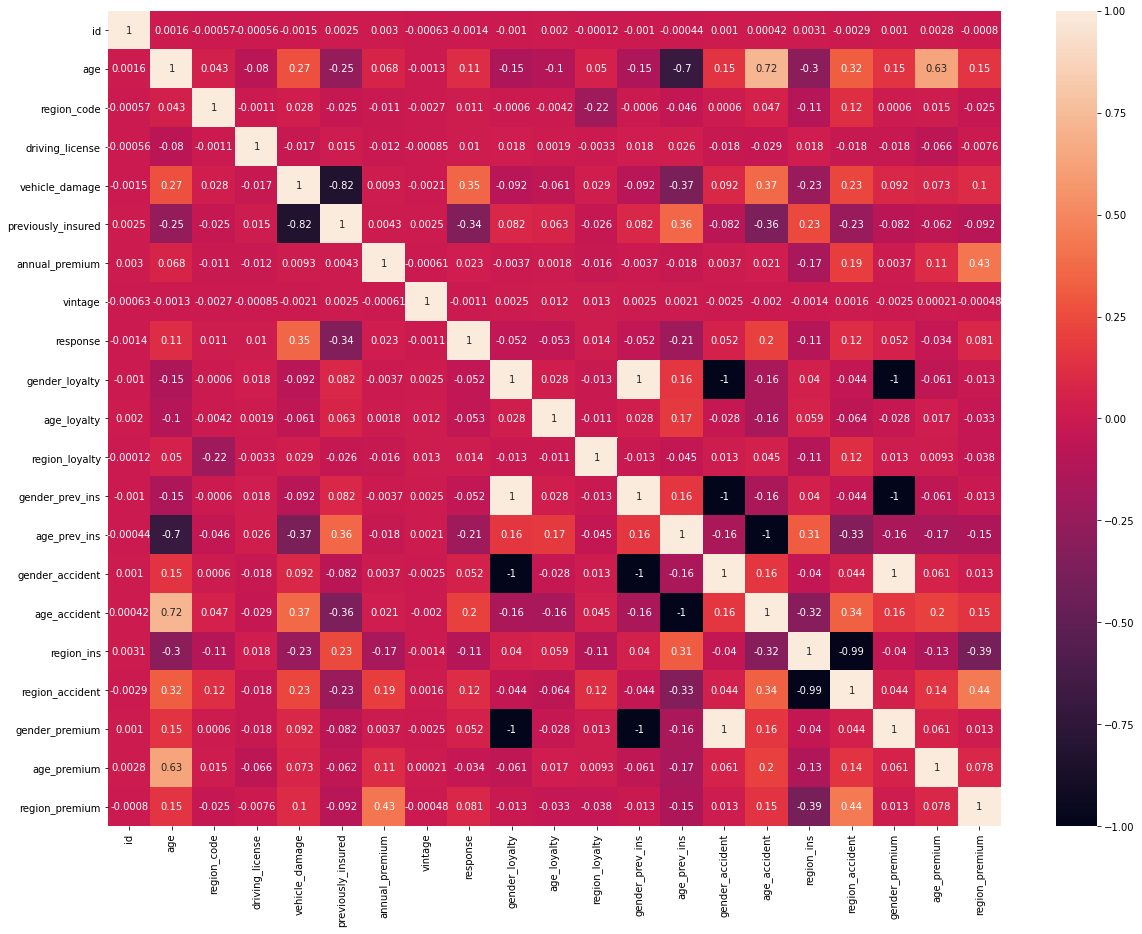

In [35]:
correl = num_attr.corr(method='pearson')
plt.figure(figsize=(20,15))
sns.heatmap(correl, annot=True);

### 4.3.2 Variáveis categóricas

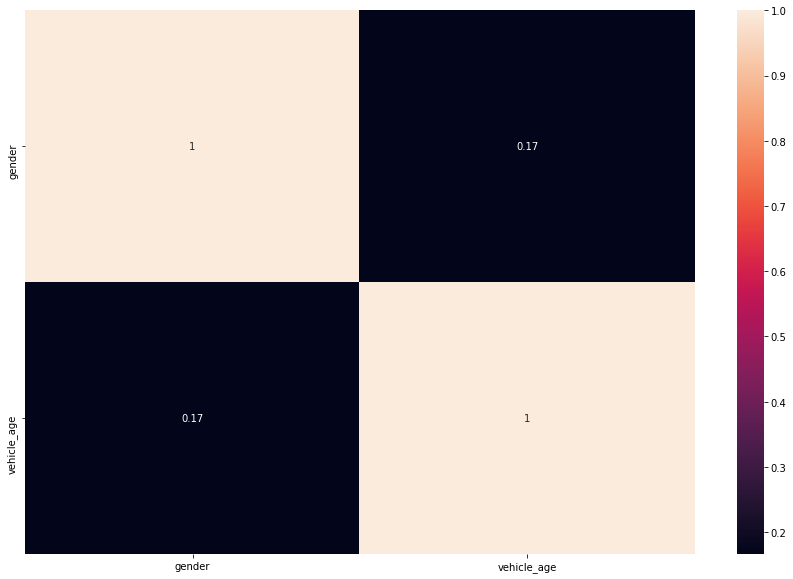

In [36]:
indexes = cat_attr.columns

#for scalability, I will create a function that returns Cramér's V correlation:

def cat_corr(x, y):
    '''Cross frequencies'''
    cont_mat = pd.crosstab(x, y).to_numpy()
    
    n = cont_mat.sum()
    r, k = cont_mat.shape
    
    '''chi square statistics'''
    chi2 = ss.chi2_contingency(cont_mat)[0]
    
    '''Corrected variables to compensate for bias:'''
    chi2corr = max(0, (chi2/n) - (k - 1)*(r - 1)/(n-1))
    r_corr = r - (r-1)**2/(n-1)
    k_corr = k - (k-1)**2/(n-1)
    
    '''Cramérs V correlation'''''
    cramer_v = np.sqrt((chi2corr)/(min(k_corr-1, r_corr-1)))
    return cramer_v


d = defaultdict(list)
#d = {}
for x, y in prod(indexes, repeat=2):
    d[x].append(cat_corr(cat_attr[x],cat_attr[y]))

a = pd.DataFrame(d, index=indexes)

plt.figure(figsize=(15,10))
sns.heatmap(a, annot=True);

# 5.0 Data Preparation

In [37]:
df5 = df4.copy()

I will remove the feature 'vehicle_damage' because it was the only feature being selected by Boruta. The information of this feature is in 'gender_accident', 'age_accident' and 'region_accident'.

In [38]:
df5 = df5.drop(columns=['vehicle_damage', 'previously_insured'])

In [39]:
num_attr = df5.select_dtypes(include=('int64', 'float64'))
cat_attr = df5.select_dtypes(include=['object'])

In [40]:
num_attr.head()

,id,age,region_code,driving_license,annual_premium,vintage,response,gender_loyalty,age_loyalty,region_loyalty,gender_prev_ins,age_prev_ins,gender_accident,age_accident,region_ins,region_accident,gender_premium,age_premium,region_premium
0,1,44,28,1,40454.0,217,1,154.153327,152.593395,154.396965,0.420590,0.269714,0.547084,0.690559,0.311817,0.660020,30622.649122,31227.811894,38668.865245
1,2,76,3,1,33536.0,183,0,154.153327,150.194126,155.211437,0.420590,0.378940,0.547084,0.599570,0.488704,0.478435,30622.649122,34640.320201,24524.480813
2,3,47,28,1,38294.0,27,1,154.153327,154.055503,154.396965,0.420590,0.274793,0.547084,0.692423,0.311817,0.660020,30622.649122,31410.618827,38668.865245
3,4,21,11,1,28619.0,203,0,154.153327,155.275324,154.607777,0.420590,0.528650,0.547084,0.445039,0.619367,0.357777,30622.649122,30591.404448,27607.283146
4,5,29,41,1,27496.0,39,0,154.575917,153.648136,154.933089,0.502508,0.618791,0.455177,0.337057,0.564694,0.416470,30495.787990,27865.179297,30949.127471


In [41]:
cat_attr.head()

,gender,vehicle_age
0,Male,> 2 Years
1,Male,1-2 Year
2,Male,> 2 Years
3,Male,< 1 Year
4,Female,< 1 Year


## 5.1 Normalization

Normalization is more adequate when working with normal distributions. The univariate analysis shows that none of the features is represented by a normal distribution, so this step will not be performed now.

## 5.2 Rescaling

Some numerical attributes will be rescaled.

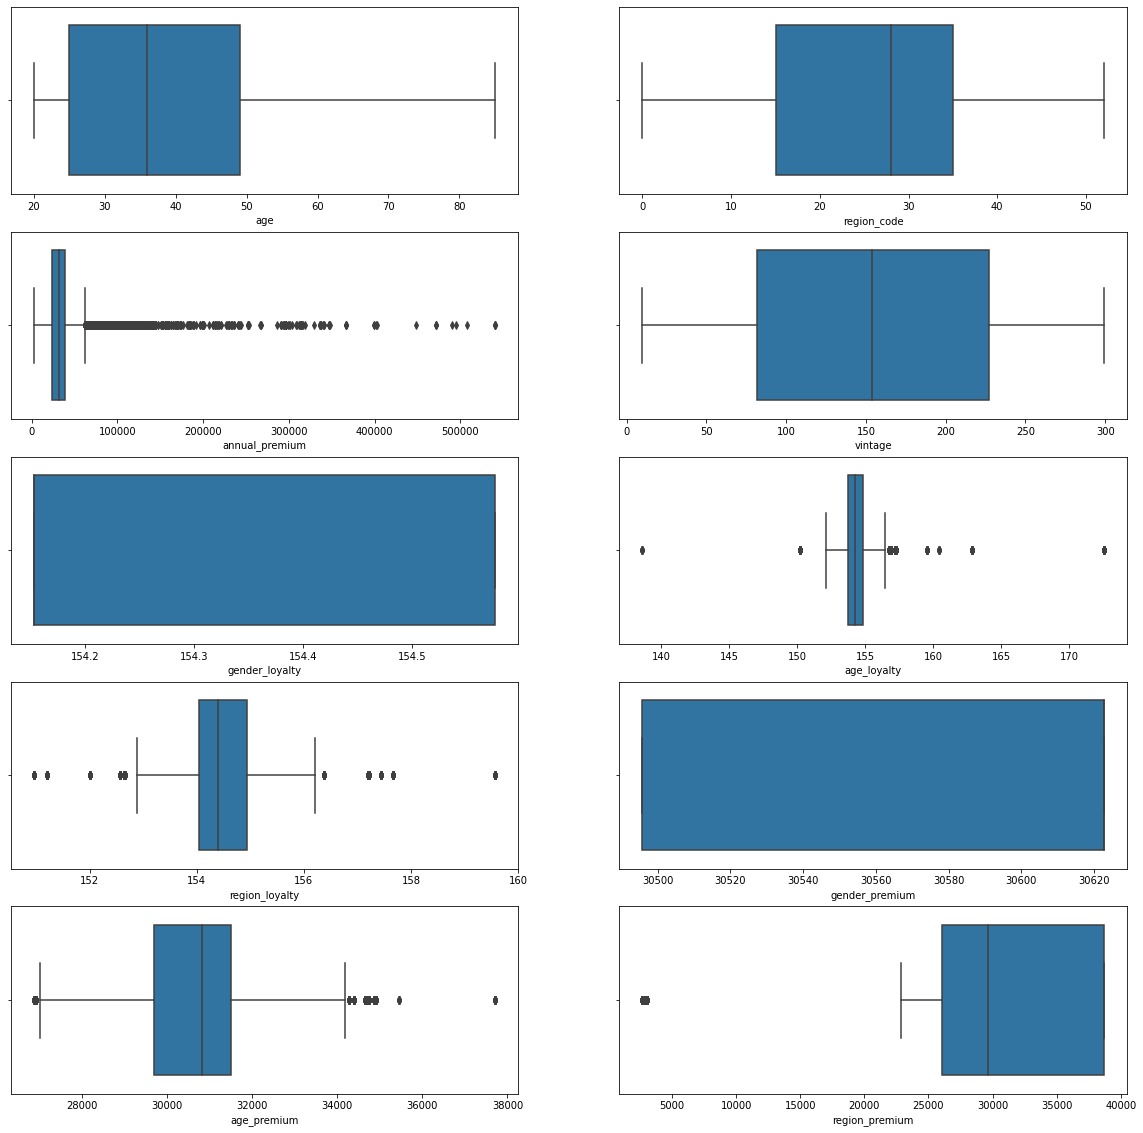

In [42]:
plt.figure(figsize=(20, 20))


plt.subplot(5, 2, 1)
sns.boxplot(data=df5, x='age');

plt.subplot(5, 2, 2)
sns.boxplot(data=df5, x='region_code');

plt.subplot(5, 2, 3)
sns.boxplot(data=df5, x='annual_premium');

plt.subplot(5, 2, 4)
sns.boxplot(data=df5, x='vintage');

plt.subplot(5, 2, 5)
sns.boxplot(data=df5, x='gender_loyalty');

plt.subplot(5, 2, 6)
sns.boxplot(data=df5, x='age_loyalty');

plt.subplot(5, 2, 7)
sns.boxplot(data=df5, x='region_loyalty');

plt.subplot(5, 2, 8)
sns.boxplot(data=df5, x='gender_premium');

plt.subplot(5, 2, 9)
sns.boxplot(data=df5, x='age_premium');

plt.subplot(5, 2, 10)
sns.boxplot(data=df5, x='region_premium');

In [43]:
rs = RobustScaler()
minmax = MinMaxScaler()


df5['age'] = minmax.fit_transform(df5[['age']].values)

df5['region_code'] = minmax.fit_transform(df5[['region_code']].values)

df5['annual_premium'] = rs.fit_transform(df5[['annual_premium']].values)

df5['vintage'] = minmax.fit_transform(df5[['vintage']].values)

df5['gender_loyalty'] = minmax.fit_transform(df5[['gender_loyalty']].values)

df5['age_loyalty'] = rs.fit_transform(df5[['age_loyalty']].values)

df5['region_loyalty'] = rs.fit_transform(df5[['region_loyalty']].values)

df5['gender_premium'] = minmax.fit_transform(df5[['gender_premium']].values)

df5['age_premium'] = rs.fit_transform(df5[['age_premium']].values)

df5['region_premium'] = rs.fit_transform(df5[['region_premium']].values)

## 5.3 Transformation

### 5.3.1 Encoding

In [44]:
#encode numerical variables with values between 0 and n_classes-1
le = LabelEncoder()

#vehicle_age
df5['vehicle_age'] = le.fit_transform(df5['vehicle_age'])

#gender: "One-hot" encoder
df5['gender'] = pd.get_dummies(df5, prefix='gender', columns=['gender'])

The target variable doesn't need to be transformed. And since there are no cyclic variables, no nature transformation is necessary either.

### 5.3.2 Export prepared data

In [45]:
df5.to_pickle('df5.pkl')